# Load dataset:

In [1]:
from components.models.utils import train_test_split
from components.datasets.dataset_factory import dataset_factory
from components.datasets.dataset_enum import Dataset
from components.text_handler.embedding.embedding_enum import EmbeddingType
from components.text_handler.embedding.embedding_factory import embedding_factory

embedding = embedding_factory(EmbeddingType.GLOVE)
dataset = dataset_factory(Dataset.GO_EMOTIONS, embedding)
train_dataset_data, train_dataset_labels, test_dataset_data, test_dataset_labels = train_test_split(dataset, 0.8)
train_size = len(train_dataset_data)
test_size = len(test_dataset_data)


# Create model:
* Only GRU for now

In [2]:
import os
import torch
from torch import nn
from components.models.algorithms.gru import GRU

input_size = 100
output_size = 28 # we have 28 labels
hidden_size = 64
learning_rate = 0.0004
batch_size = 32
num_epochs = 10

dirname = os.path.dirname("__file__")
saved_data_path = os.path.join(dirname, "components")
saved_data_path = os.path.join(saved_data_path, "models")
saved_data_path = os.path.join(saved_data_path, "saved_models")
PATH = os.path.join(saved_data_path, "gru_model.pth")

device = torch.device('cpu')

model = GRU(input_size, output_size, hidden_size).to(device)
if os.path.exists(PATH):
    model.load_state_dict(torch.load(PATH))

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define metrics objects:

In [3]:
from torchmetrics import Accuracy, AUROC, Precision
from sklearn.metrics import f1_score
import numpy as np

accuracy = Accuracy().to(device)
area_under_roc = AUROC(pos_label=1).to(device)
F1_score = lambda prediction, labels : f1_score(labels, np.round(prediction.detach().numpy()), average='macro')
precision = Precision().to(device)

/Users/nadavalali/opt/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


# Train model:

In [4]:
from components.models.algorithms.feed_nn_model import feed_model, LOSS, TRAIN, TEST, ACC, AUROC, F1, PRECISION
from components.models.utils import shuffle
from tqdm import tqdm

measurements = {
    LOSS: {TRAIN: [], TEST: []},
    ACC: {TRAIN: [], TEST: []},
    AUROC: {TRAIN: [], TEST: []},
    F1: {TRAIN: [], TEST: []},
    PRECISION: {TRAIN: [], TEST: []}
}

for epoch in tqdm(range(num_epochs)):

    # train the model
    model.train()
    feed_model(model, hidden_size, train_dataset_data, train_dataset_labels, train_size,
               batch_size, criterion, optimizer, accuracy, area_under_roc, F1_score, precision, measurements, TRAIN, device)

    # test the model
    model.eval()
    feed_model(model, hidden_size, test_dataset_data, test_dataset_labels, test_size,
               batch_size, criterion, optimizer, accuracy, area_under_roc, F1_score, precision, measurements, TEST, device)

    # shuffle train set
    train_dataset_data, train_dataset_labels = shuffle(train_dataset_data, train_dataset_labels)

torch.save(model.state_dict(), PATH)

100%|██████████| 5/5 [08:39<00:00, 103.98s/it]


# Plot results:

Plotting results:

loss: train=0.12432867251604784, test=0.12411115506494587


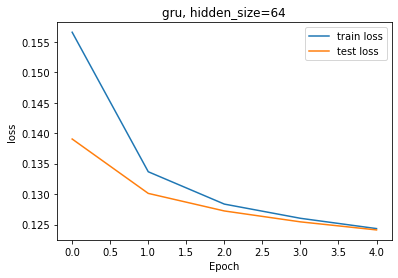

accuracy: train=0.9607184529304504, test=0.9607481956481934


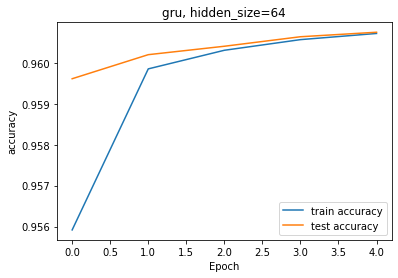

area under ROC curve: train=0.8773145079612732, test=0.8771715760231018


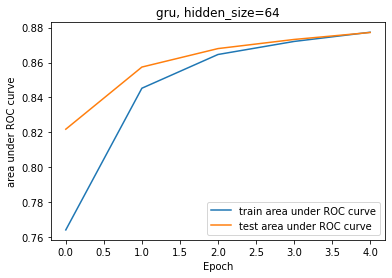

F1 accuracy: train=0.60636724152017, test=0.6116833842327669


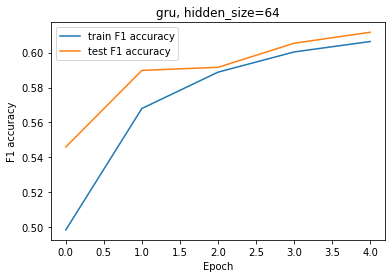

precision: train=0.6616509556770325, test=0.6398347616195679


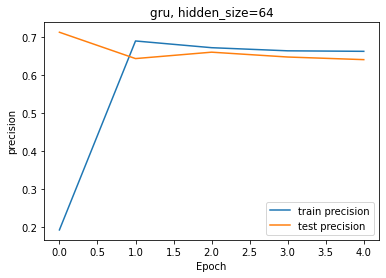

In [5]:
from matplotlib import pyplot as plt

if len(measurements[LOSS][TRAIN]):
    print("Plotting results:\n")
    for measurement_key, measurement in measurements.items():
        print(f"{measurement_key}: train={measurement[TRAIN][-1]}, test={measurement[TEST][-1]}")

        plt.title(f'{"gru"}, hidden_size={hidden_size}')
        plt.xlabel('Epoch')
        plt.ylabel(measurement_key)
        plt.plot(measurement[TRAIN], label=f'train {measurement_key}')
        plt.plot(measurement[TEST], label=f'test {measurement_key}')
        plt.legend()
        plt.show()
else:
    print("You didn't run the training step!")